# Assignment 2 - Adrian Sandoval-Vargas, Mohamed Almukhtar
Naive Bayes with Bag of Words

## Import all of our libraries

In [5]:
import numpy as np # Linear Algebra
import pandas as pd # Data processing
from wordcloud import WordCloud # Visualization
import regex as re # Text processing
import matplotlib.pyplot as plt # Visualization
from textblob import Word, TextBlob # Text features
import nltk # Text Manipulation
nltk.download('wordnet') # Download wordnet
nltk.download('punkt') # Download punkt
nltk.download("stopwords") # Download Stopwords
nltk.download("omw-1.4")  # Download omw-1.4
from nltk.corpus import words as dict_words #contains english word dictionary
from nltk.corpus import stopwords #contains stop words
from sklearn.model_selection import train_test_split # split out data into training and testing sets

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malmukhtar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malmukhtar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malmukhtar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/malmukhtar/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


## Data Preprocessing
* Read Dataset
* Perform text manipulation




In [2]:
original_data_frame = pd.read_csv("data/tweet_emotions.csv")
# Make a copy of the dataframe for manipulation
data = original_data_frame.copy()
data.drop("tweet_id", axis=1, inplace=True); # Drop the tweet_id as it is irrelevant
data = data[data['sentiment'].isin(['happiness','sadness'])].reset_index(drop=True) # Reset the indexes

### Helper Functions

In [3]:
def remove_unwanted_text(content):
  '''
  Removes unwanted text from content using regex
  Input
  content: A string
  Output
  final: the final parsed string
  '''
  handle = re.sub('@[^\s]+', '', content)
  link = re.sub('http[^\s]+', '', handle)
  link = re.sub('www[^\s]+', '', link)
  ht = re.sub('#[^\s]+', '', link)
  final = re.sub('&[^\s]+', '', ht)
  #final = re.sub('[\d]', '', ht)
  return final

def stem(words):
  '''
  Input
  words: words to be processed
  Output
  returns array of stemmed words
  '''
  tb = TextBlob(' '.join(words))
  return [w for w in tb.words.stem()]

def lemmatize(words):
  '''
  Input
  words: words to be processed
  Output
  returns array of lemmatized words
  '''
  tb = TextBlob(' '.join(words))
  return [w for w in tb.words.lemmatize()]

def correct_words(words):
  '''
  Corrects a word using TextBlob
  Input
  words: a list of words
  Output
  returns corrected words
  '''
  return [Word(w).correct() for w in words]
    
def word_frequency(text):
  '''
  Counts the words in a dataframe
  Input
  text: text to be counted
  Output
  word frequecy in text
  '''
  tb = TextBlob(text)
  return tb.word_counts

def remove_punctuations(words):
  '''
  Input
  words: A list of words to be processed
  Output
  returns a list of words that punctuations and numbers have been removed. 
  '''
  new_words = []
  for w in words:
      l = re.sub('[^A-Za-z ]+', '', w)
      if l != '':
          new_words.append(l)
          
  return new_words

def remove_stop_words(words):
  '''
  Input
  words: Words to be processed
  Output
  returns a list of words without english stopwords
  '''
  sw = stopwords.words("english") # English Stop Words
  sw.append('could') # should be in sw since wouldn't and couldn't are in (lemmatization or stem don't convert)
  sw.append('would') # should be in sw since wouldn't and couldn't are in (lemmatization or stem don't convert)
  sw.append('nt') # nt appears a lot
  sw.append('im') # im appears a lot
  sw = remove_punctuations(sw)

  return [w for w in words if w.lower() not in sw]

def clean_data(content):
  '''
  Cleans the incoming data
  Input
  content: a dataframe series
  '''
  for i in range(len(content)):
      tweet = remove_unwanted_text(content[i].lower())
      tb = TextBlob(tweet)
      words = remove_punctuations(tb.words)
      words = remove_stop_words(words)

      lemmatized_words = lemmatize(words) # for the most part this was good
      words = [w for w in lemmatized_words if len(w)>1] # removes any character of len 1 usually a "u" or "n"
      data.loc[i, 'content'] = " ".join(words)

def get_array(text):
  '''
  Returns the text into an array format
  '''
  return text.split(" ")      

def get_entire_text(content):
  '''
  Return the entire text in a dataframe series
  '''
  entire_text = ""
  for i in content:
      entire_text += i + " "
  return entire_text

def display_top_words(wf, k=20):
    '''
    Displays the top words in a data set
    Input
    k: Number of top words to display. Defaults to 20.
    Output displays top [k] values
    '''
    wf_sorted = sorted(wf.items(), key=lambda x: x[1], reverse=True)
    wf_sorted_greater_than_1 = [w for w in wf_sorted if w[1] > 1]
    top = wf_sorted_greater_than_1[:k:]
    x = [x[0] for x in top]
    y = [y[1] for y in top]
    %matplotlib inline
    plt.figure(figsize=(20,10))
    plt.bar(x, y)
    plt.xticks(rotation=45)
    plt.show()

def display_wordcloud(words):
    '''
    Displays wordcloud
    '''
    wc = WordCloud()
    wc.generate(words)
    %matplotlib inline 
    plt.imshow(wc)

## Cleaning 

In [6]:

clean_data(data['content']) # cleans the data
text = get_entire_text(data['content'])
wf = word_frequency(text) # Word Frequency 

### Visuals

Displays a word cloud of the data

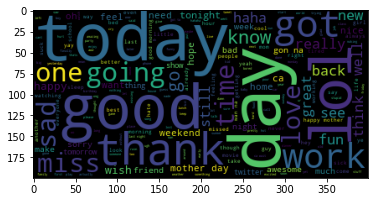

In [7]:
display_wordcloud(text)

Displays top 20 words in the data

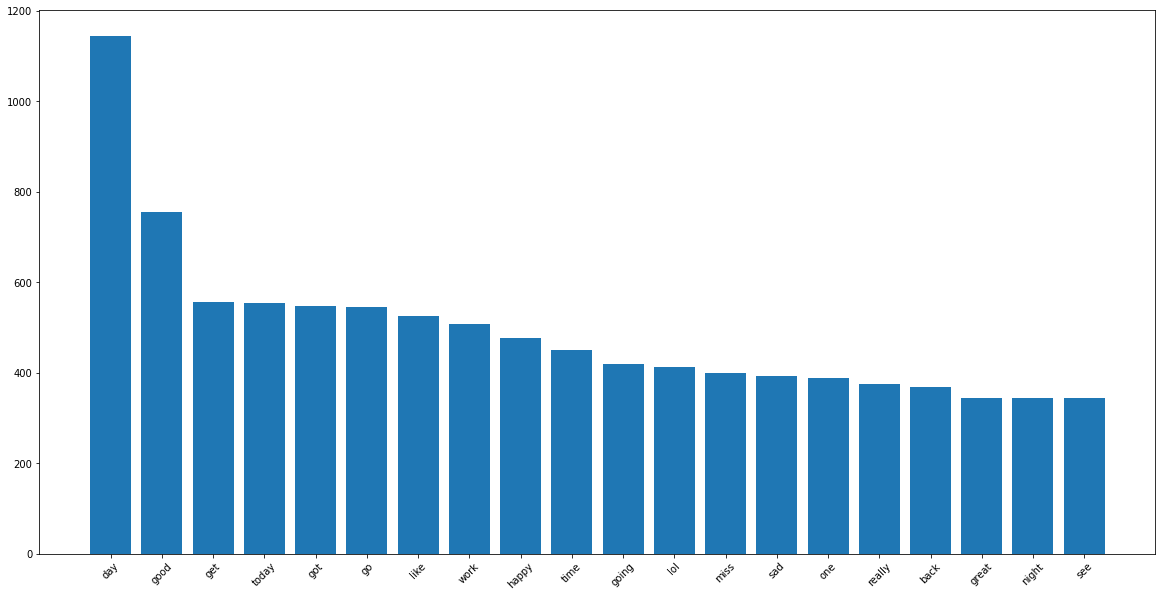

In [8]:
display_top_words(wf)

## Data Preparation
Splits our data in to train **80%** and test **20%**

In [9]:
train, test = train_test_split(data, random_state=0, test_size=0.2)

## Naive Bayes Model

In [10]:
def bag_of_words(data, labels, counts):
  label_counts = data['sentiment'].value_counts().to_dict()
  for label in labels:
    if label in label_counts:
      counts['labels'][label] = label_counts[label]

  # Bow 
  for row in range(len(data)):
    words  = get_array(data.iloc[row]['content'])
    for word in words:
          for label in labels:
            if data.iloc[row]['sentiment'] == label:
              if word in counts[label]:
                counts[label][word]+=1
              else:
                counts[label][word]=1 

          # used to calculate proabaility of each word 
          if word in counts["words"].keys(): 
              counts["words"][word]+=1
          else:
              counts["words"][word]=1
    
  return counts

## Prediction function 

Using the equation $Y^{new} = argmax(P(Y = y_k) \prod_{i = 1}^{|W|} p(x_i|Y=y_k))$

And $p(x_i|Y=y_k) = $ $\frac{n_i+1}{n+|W|}$

Where:
* $P(Y = y_k)$ is represented by the hash table $result[label]$ prior to calculating $\prod_{i = 1}^{|W|} p(x_i|Y=y_k))$, and the result is stored in the same hash table.
* ${n_i}$ is represented by $counts[label][word]$, the word count for a specicfic label.
* $n$ is represented by $sum(counts[label].values())$ where this is the number of words for a specific label.
* ${|W|}$ is represented by $len(counts['words'].keys())$ is the count of total words in the BoW.





In [11]:
def predict(test_data, labels, counts):
  accuracy = 0
  label_probability = {}
  no_labels = test_data['sentiment'].shape[0]
  for label in labels:
    label_probability[label] =  counts['labels'][label] / no_labels

  for row in range(len(test_data)):
      tweet = test.iloc[row]['content']
      target = test.iloc[row]['sentiment']
      words = get_array(tweet)

      # copying the labels probability to result dict to use it for the naive bayes predection equation.
      result = {}
      for label in labels:
        result[label] = label_probability[label]



      # Calculating 𝑝(𝑥𝑖|𝑌=𝑦𝑘)=  (𝑛𝑖+1)/(𝑛+|𝑊|)   for all y  
      for word in words:
          for label in labels:
            if word in counts[label].keys():
              result[label] *= ((counts[label][word] + 1)/(sum(counts[label].values())+len(counts['words'].keys())))  # The representation of the equation (𝑛𝑖+1)/(𝑛+|𝑊|)
            else:
              result[label] *= (1/(sum(counts[label].values())+len(counts['words'].keys()))) # if the word doesn's exit we are only left with the term 1/(𝑛+|𝑊|) as 𝑛𝑖 is 0

      predection = max(result, key=result.get) # argmax


      if target == predection:
          accuracy += 1

  return(accuracy/len(test_data)*100)

## Variables Initialization

In this cell a hash table is being initialized to store all the counts that will be done during the training. The hash table was dynamically created to accept $n$ labels.

**The hash table structure is as follows:**



```
counts = {
     'count': {
          "total": 0,
          "label1": 0,
          "label2": 0,
          rest of the labels..
     },
     'words':{
          "word1": 1,  => the appearance of word1 in the whole dataset
          "word2": 2,
          rest of the labels..
     }, 
     'labels': {
            "label1": 0 => total number of rows matches this label
            "label2": 0 => total number of rows matches this label

     }, 
     'label1' :{
            "word1": 1,  => the appearance of word1 in rows matches label1
            "word2": 2,  => the appearance of word2 in rows matches label1
            etc.. 
     }, 
     'label1' :{
            "word1": 1,  => the appearance of word1 in rows matches label2
            "word2": 2,  => the appearance of word2 in rows matches label2
            etc.. 
     }
      rest of the labels..
 }
```




In [12]:
labels = train['sentiment'].unique()
counts = {"count": {"total": 0}, "words": {}, "labels": {}}
word_per_label_probability = {}

for label in labels:
  counts["count"][label] = 0
  counts[label] = {}
  word_per_label_probability[label] = {}

## Train model

In [13]:
counts = bag_of_words(train,labels, counts)

## Results

In [14]:
accuracy = predict(test,labels,counts)

print(f"Accuracy:\t{accuracy:.2f}%")

Accuracy:	78.17%


## Conclusion



### Data

Tweets are generally slang language with bad spelling which affects the learning and prediction process but nonetheless with the data processing we managed to get a fair data set.

Below are some scenerios we ran into.

Lemmatizing and correcting the words led to some words being fixed while others it completely changed the meaning.

Original Tweet:
 
*@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[*

* Lemmatized: ['know', 'listenin', 'bad', 'habit', 'earlier', 'started', 'freakin', 'part']
* Correcting the words: ['know', 'listening', 'bad', 'habit', 'earlier', 'started', 'breaking', 'part']

Original Tweet:

*funeral ceremony...gloomy friday...*

* Lemmatized: ['funeral', 'ceremony', 'gloomy', 'friday']
* Stemmed: ['funer', 'ceremoni', 'gloomi', 'friday']
* Corrected: ['finer', 'ceremony', 'gloomy', 'friday']

As we can see the lemmatized was the best way to get the words to a base without much processing.

### Results

We tried 13 labels from the dataset but had a low performance due to the lack of label distribution so we selected two labels with opposite sentiment which are "happiness" and "sadness". This resulted in the model performing better.